# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - Repaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя
 
 
Целевой признак
 - Price — цена (евро)

## Подготовка данных

### Общий анализ данных

In [853]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #графики
import seaborn as sns
import time
from sklearn.model_selection import train_test_split, GridSearchCV  #деление выборок/подбор гиперпараметров
from sklearn.preprocessing import StandardScaler, OneHotEncoder #масштабирование/кодирование
from sklearn.linear_model import LinearRegression, Ridge 
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error #mse
#import warnings
#warnings.filterwarnings('ignore') #игнорирование ошибок при построении графиков
from sklearn.dummy import DummyRegressor
from sklearn.metrics import  make_scorer


In [854]:
# чтение файла
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')
    
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [855]:
#просмотр общей информации
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные содержат 354369 строк, 9 столбцов с категориальными данными, 7 с количественными

In [856]:
#замена названий, приведение к нижнему регистру
df.columns = df.columns.str.lower()
print(df.columns)

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')


In [857]:
#проверка пропусков
print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
print(df.isnull().sum())
#доля пропусков в столбцах
print ('\033[1m' + '\nДоля пропусков в столбцах'+ '\033[0m')
pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm')


Проверка пропусков
datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
repaired             71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Доля пропусков в столбцах


,0
datecrawled,0.000000
price,0.000000
vehicletype,11.000000
registrationyear,0.000000
gearbox,6.000000
power,0.000000
model,6.000000
kilometer,0.000000
registrationmonth,0.000000
fueltype,9.000000


Большое количество пропусков: 
 - vehicletype ( тип кузова) - 11%
 - gearbox(коробка передач) - 6%
 - model( модель) - 6%
 - fueltype(тип топлива)- 9%
 - repaired (был ли ремонт) - 20%

In [858]:
#проверка на дубликаты
print(df.duplicated().sum())

4


In [859]:
#просмотр дубликатов
df[df.duplicated()]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Так как нет опознавательных признаков в виде id - предположим, что это разные предложения, со схожими характеристиками

In [860]:
#описание количественных данных
display(df.describe().round(2).T)

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.66,4514.16,0.0,1050.0,2700.0,6400.0,20000.0
registrationyear,354369.0,2004.23,90.23,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.09,189.85,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.17,37905.34,5000.0,125000.0,150000.0,150000.0,150000.0
registrationmonth,354369.0,5.71,3.73,0.0,3.0,6.0,9.0,12.0
numberofpictures,354369.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
postalcode,354369.0,50508.69,25783.10,1067.0,30165.0,49413.0,71083.0,99998.0


Вопросы для для дальнейшей проверки/изучения данных:
 - в первую очередь бросается в глаза цена (price) со значением 0.
 - год регистрации(registrationyear) от 1000 до 9999
 - мощность (power) от 0 до 20000 (такие существуют?)
 - количество фотографиий(numberofpictures) - все значения равное 0
 

In [861]:
#описание категориальных данных
display(df.describe(include='object').T)

,count,unique,top,freq
datecrawled,354369,271174,2016-03-24 14:49:47,7
vehicletype,316879,8,sedan,91457
gearbox,334536,2,manual,268251
model,334664,250,golf,29232
fueltype,321474,7,petrol,216352
brand,354369,40,volkswagen,77013
repaired,283215,2,no,247161
datecreated,354369,109,2016-04-03 00:00:00,13719
lastseen,354369,179150,2016-04-06 13:45:54,17


Общие замечания/пометки:
- 8 видов кузова (vehicletype), самый частый вариант - седан. Количество пропусков - 11%
- 2 вида коробки передач(gearbox), больше предложений с ручным вариантов(manual). Количество пропусков - 6%
- 250 моделей(model).Количество пропусков 6%
- 7 типов топлива (fueltype). Количество пропусков - 9%
- 40 брендов (brand). Проупусков данных нет.
- Налачие каких то ремонтов(repaired). Количество пропусков - 20%

In [862]:
# для отображения количества уникальных значений в каждом столбце
# from_records: создает объект DataFrame из структурированного массива

unique_counts = pd.DataFrame.from_records([(col, df[col].nunique()) for col in df.columns],
                                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])
print(unique_counts)

          Column_Name  Num_Unique
13   numberofpictures           1
4             gearbox           2
11           repaired           2
9            fueltype           7
2         vehicletype           8
7           kilometer          13
8   registrationmonth          13
10              brand          40
12        datecreated         109
3    registrationyear         151
6               model         250
5               power         712
1               price        3731
14         postalcode        8143
15           lastseen      179150
0         datecrawled      271174


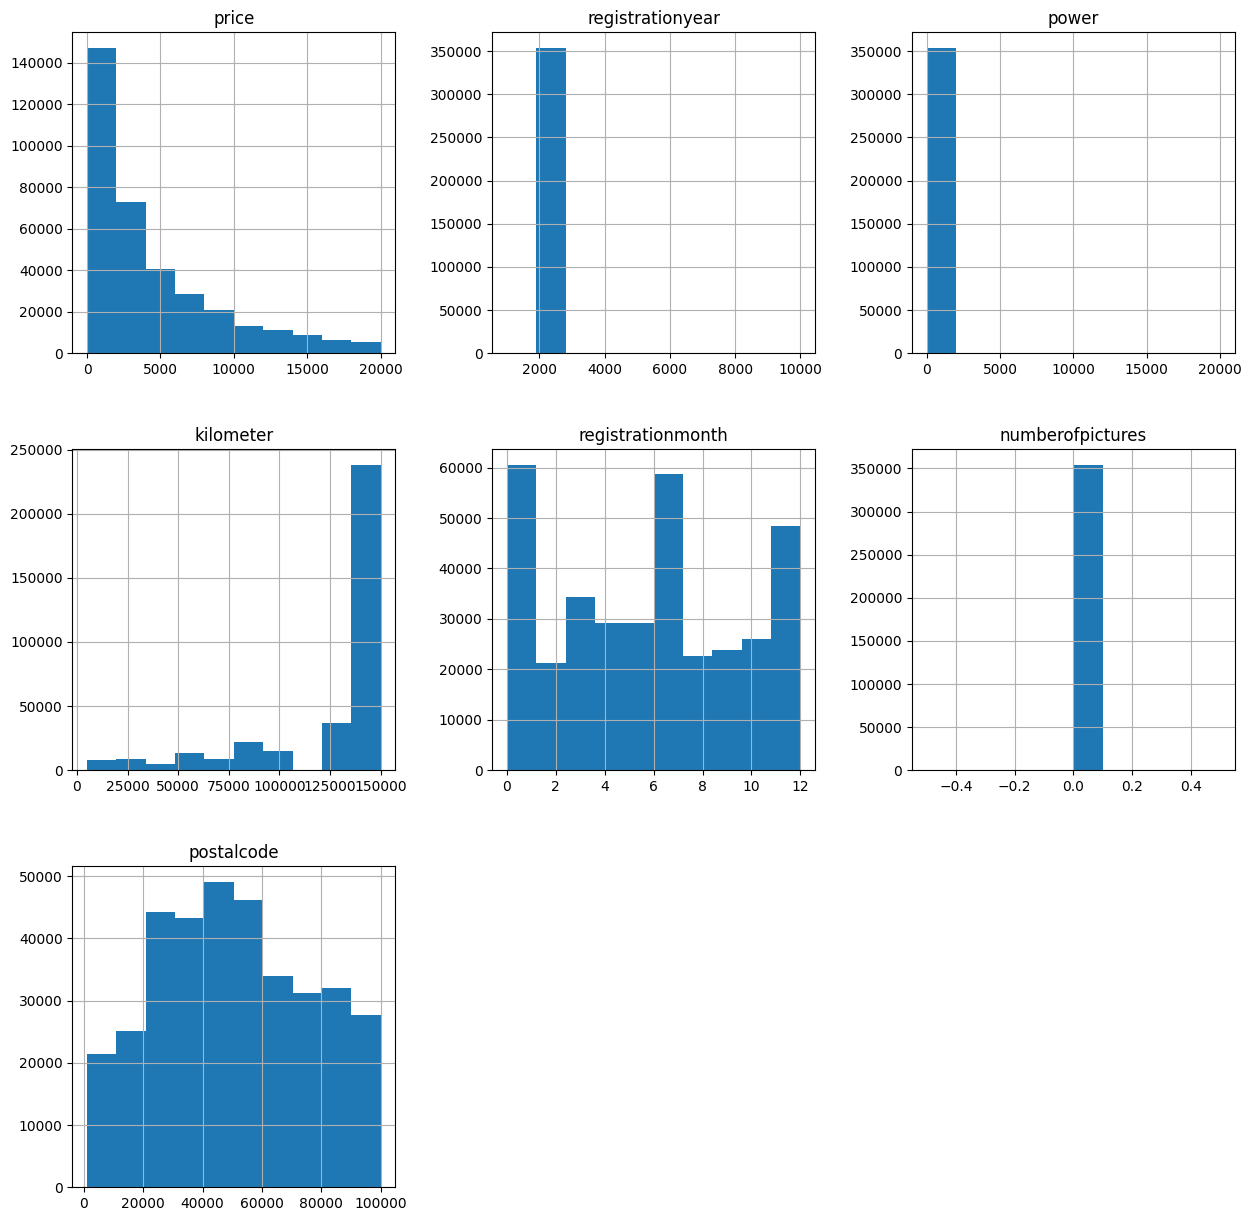

In [863]:
# графическое представление данных из таблиц
df.hist(figsize=(15, 15))
plt.show()

Графики лишь подверждают необходимость детального изучения данных в столбце:
- Price - данные со значением 0 
- год регистрации  - проверить и удалить выбросы 

#### Анализ данных в столце Price

In [864]:
#просмотр строк со значением 0 в столбце Price
print ('\033[1m' + '\nКоличество строк со значением 0 в столбце price'+ '\033[0m')
print(len(df.loc[df['price']== 0] ))
display(df.loc[df['price']== 0])


Количество строк со значением 0 в столбце price
10772


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
111,2016-03-19 18:40:12,0,NaN,2017,manual,0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19 00:00:00,0,21698,2016-04-01 08:47:05
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000,manual,65,corsa,150000,0,NaN,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,NaN,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,NaN,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes,2016-03-10 00:00:00,0,22559,2016-03-12 23:46:32


10772  строк со значением 0 в столбце price (3% от общих данных).

Так как это целевой признак, и важный для анализа, удалим эти строки

In [865]:
#удаление строк со значением 0 в целевом признаке
df = df.loc[df['price']!= 0]
#проверка
print(len(df.loc[df['price']== 0] ))
df.info()       

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        343597 non-null  object
 1   price              343597 non-null  int64 
 2   vehicletype        309847 non-null  object
 3   registrationyear   343597 non-null  int64 
 4   gearbox            326242 non-null  object
 5   power              343597 non-null  int64 
 6   model              326076 non-null  object
 7   kilometer          343597 non-null  int64 
 8   registrationmonth  343597 non-null  int64 
 9   fueltype           314138 non-null  object
 10  brand              343597 non-null  object
 11  repaired           277731 non-null  object
 12  datecreated        343597 non-null  object
 13  numberofpictures   343597 non-null  int64 
 14  postalcode         343597 non-null  int64 
 15  lastseen           343597 non-null  object
dtypes: int64(7), objec

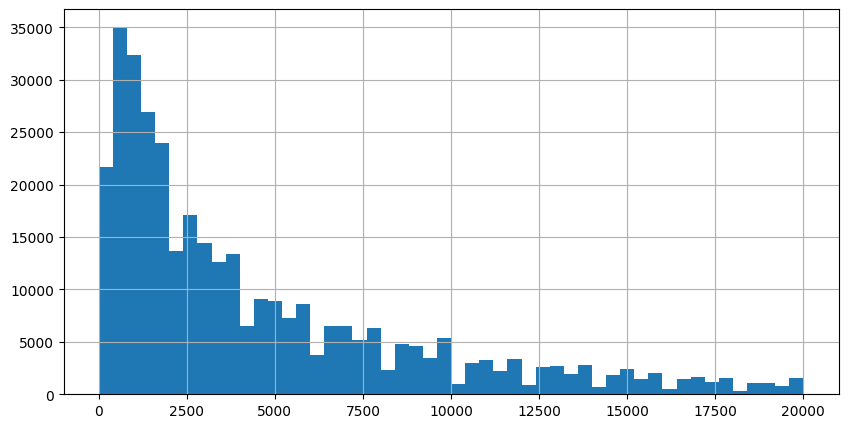

In [866]:
# графическое представление данных из таблиц
df['price'].hist(figsize=(10, 5), bins =50)
plt.show()

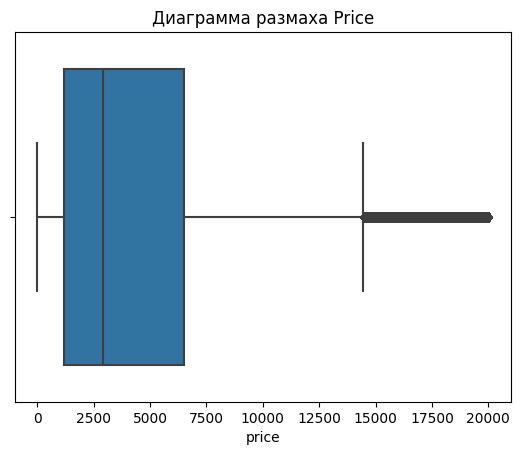

In [867]:
sns.boxplot(df['price'])
plt.title('Диаграмма размаха Price')
plt.show()

Картина лучше, но еще наблюдаются данные со значением близко к 0.Проверим их

In [868]:
#просмотр строк с ценой менее 10 евро
print(len(df.loc[df['price']<=  10] ))
display(df.loc[df['price']<= 10])

1340


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11 00:00:00,0,55122,2016-03-26 23:15:49
408,2016-03-29 18:51:58,1,NaN,2000,NaN,75,golf,90000,3,petrol,volkswagen,NaN,2016-03-29 00:00:00,0,78588,2016-04-06 04:45:50
901,2016-03-06 00:25:25,1,NaN,1990,manual,0,other,150000,0,NaN,porsche,NaN,2016-03-05 00:00:00,0,65843,2016-04-06 20:19:08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353252,2016-03-09 13:48:39,1,coupe,1990,manual,45,polo,150000,0,petrol,volkswagen,no,2016-03-09 00:00:00,0,26160,2016-03-25 07:18:43
353584,2016-03-31 17:56:10,1,NaN,2000,NaN,0,NaN,10000,0,NaN,sonstige_autos,NaN,2016-03-31 00:00:00,0,52525,2016-03-31 18:42:13
353682,2016-03-07 13:53:17,1,bus,1999,manual,0,espace,150000,0,petrol,renault,NaN,2016-03-07 00:00:00,0,57439,2016-03-08 16:51:26
353727,2016-03-20 17:56:59,1,NaN,2000,NaN,0,NaN,150000,0,NaN,bmw,NaN,2016-03-20 00:00:00,0,42329,2016-04-07 00:46:36


1256 строк со странными данными, даже можно обнаружить Porshe за 1 евро. Чтоб общая картина не страдала, удалим и эти странные данные.

In [869]:
#удаление строк с ценой ниже 10 евро(целевой признак)
df = df.loc[df['price'] > 10]
#проверка
print(len(df.loc[df['price']< 10] ))
 

0


In [870]:
df.shape[0]

342257

#### Анализ данных в дате регистрации и даты создания анкеты

Для начала изучим дату создания анкеты - какой период охватывают данные

In [871]:
# Min и max даты подачи обьявления/регитрации авто
print('Период размещения обьявлений(min-max)')
print(df['datecreated'].min())
print(df['datecreated'].max())
print('Период регистрации авто(min-max)')
print(df['registrationyear'].min())
print(df['registrationyear'].max())

Период размещения обьявлений(min-max)
2014-03-10 00:00:00
2016-04-07 00:00:00
Период регистрации авто(min-max)
1000
9999


Последнее объявление от 2016 года, значит все автомобили с регистрацией от 2017 года и выше можно смело удалить.
И посмотрим обьявления авто с годом выпуска ранее 1930 года

In [872]:
#просмотр строк с с данной регистрации авто после 2017 года 
print('Количество строк с регистрацией машины после 2017года')
print(len(df.loc[df['registrationyear']>= 2017] ))

#просмотр строк с с данной регистрации авто до 1930 года
print('Количество строк с регистрацией машины до 1930года')
print(len(df.loc[df['registrationyear']<=  1930] ))
display(df.loc[df['registrationyear']<= 1930])

Количество строк с регистрацией машины после 2017года
13710
Количество строк с регистрацией машины до 1930года
108


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired,datecreated,numberofpictures,postalcode,lastseen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016-03-15 00:00:00,0,79288,2016-04-07 05:15:34
6977,2016-03-24 08:37:22,135,NaN,1910,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-24 00:00:00,0,19374,2016-04-06 20:46:08
10183,2016-03-27 13:59:08,1250,NaN,1910,NaN,0,other,5000,0,NaN,audi,NaN,2016-03-27 00:00:00,0,18445,2016-04-07 10:45:31
16062,2016-03-29 23:42:16,190,NaN,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334901,2016-03-29 03:36:18,1300,NaN,1910,NaN,0,NaN,5000,9,NaN,audi,NaN,2016-03-29 00:00:00,0,82256,2016-04-05 17:25:59
336104,2016-03-11 11:51:33,20000,coupe,1929,manual,12,other,10000,4,petrol,bmw,NaN,2016-03-11 00:00:00,0,74523,2016-04-07 05:45:00
340759,2016-04-04 23:55:47,700,NaN,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04 00:00:00,0,86343,2016-04-05 06:44:07
351682,2016-03-12 00:57:39,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN,2016-03-11 00:00:00,0,16515,2016-04-05 19:47:27


108 строк, данные не вызывающие доверия (присутствуют такие модели, как a3  и mondeo, и цены для раритетных машин очень гуманные). Удалим эти данные,т.е. машины с регистрацией ранее 1930 года и позднее 2017 года

In [873]:
#удаление строк с датой регистрации авто до 1930 года и после 2017 
df = df.loc[(df['registrationyear']> 1930) & (df['registrationyear']< 2017)]
#проверка
print('Количество строк с регистрацией машины после 2017года')
print(len(df.loc[df['registrationyear']> 2017] ))
print('Количество строк с регистрацией машины до 1930года')
print(len(df.loc[df['registrationyear']<=  1930] ))

Количество строк с регистрацией машины после 2017года
0
Количество строк с регистрацией машины до 1930года
0


In [815]:
df.shape[0]

328439

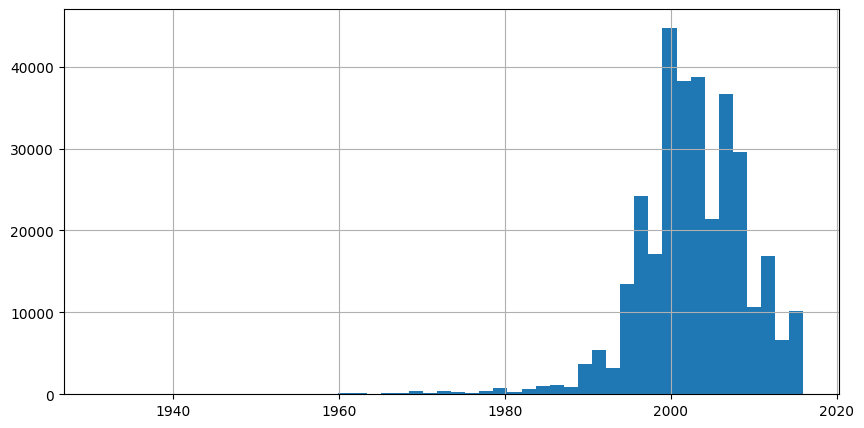

In [874]:
# итоговое представление данных с датой регистрации авто
df['registrationyear'].hist(figsize=(10, 5), bins =50)
plt.show()

#### Анализ мощности 

На сегодняшний день самой мощной машиной является машина с мощностью в 2000 лошадиных сил, минимум колеблется в районе  100-150 л.с. Так данные охватывают машины и более раних годов просмотрим количество машин с мощностью до 20л.с и более 2000

In [875]:
print('Количество машин с мощностью менее 20л.с')
print(len(df.loc[df['power']< 20] ))
print('Количество машин с мощностью более 2000л.с')
print(len(df.loc[df['power']>  2000] ))

Количество машин с мощностью менее 20л.с
32635
Количество машин с мощностью более 2000л.с
101


In [876]:
#удаление строк с мощностью менее 20 и более 2000 л.с 
df = df.loc[(df['power']>= 20) & (df['power']<= 2000)]
#проверка
print(len(df.loc[df['power']< 20] ))
print(len(df.loc[df['power']>  2000] ))
df.shape[0]

0
0


295703

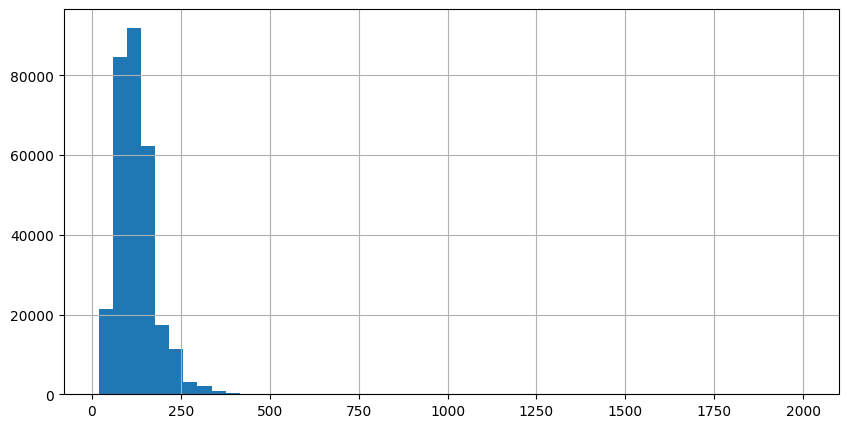

In [877]:
# графическое представление мощности
df['power'].hist(figsize=(10, 5), bins =50)
plt.show()

#### Тип топлива

In [878]:
# просмотр данных по топливу
print ('Распределение по типам топлива')
display(df['fueltype']. value_counts())
print('Количество пустых строк:',df['fueltype']. isnull().sum() )


Распределение по типам топлива


petrol      187130
gasoline     87668
lpg           4679
cng            482
hybrid         201
other           83
electric        42
Name: fueltype, dtype: int64

Количество пустых строк: 15418


Большинство автомобилей на бензине, это наиболее популярный вид топлива в настоящее время. Заменим пропуски на 'petrol' в таблице

In [879]:
#замена пустых значений в столбце fueltype на petrol
df['fueltype'].fillna('petrol', inplace=True)
#проверка
print('Количество пустых строк:',df['fueltype']. isnull().sum())

Количество пустых строк: 0


#### Тип кузова, коробка передач, модель авто, наличие ремонта

In [822]:
#Пустые строки
display(df.isnull().sum()[df.isna().sum()>0])
pd.DataFrame(round(df.isna().mean()*100)[df.isna().sum()>0])


vehicletype    10899
gearbox         5317
model          10945
repaired       42677
dtype: int64

,0
vehicletype,4.0
gearbox,2.0
model,4.0
repaired,14.0


Остались незаполнеными данные:
- тип кузова(vehicletype) - 4%,
- коробка передач(gearbox)- 2%, 
- модель авто(model)- 4%, 
- наличие ремонта(repaired)- 14%.

Так как не можем определить ни модель, ни коробку передач, ни наличие ремонта  - заменим пропуски на 'unknown'.

In [880]:
#замена пропусков на unknown
df['vehicletype'].fillna('unknown', inplace=True)
df['gearbox'].fillna('unknown', inplace=True)
df['model'].fillna('unknown', inplace=True)
df['repaired'].fillna('unknown', inplace=True)
#проверка 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295703 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        295703 non-null  object
 1   price              295703 non-null  int64 
 2   vehicletype        295703 non-null  object
 3   registrationyear   295703 non-null  int64 
 4   gearbox            295703 non-null  object
 5   power              295703 non-null  int64 
 6   model              295703 non-null  object
 7   kilometer          295703 non-null  int64 
 8   registrationmonth  295703 non-null  int64 
 9   fueltype           295703 non-null  object
 10  brand              295703 non-null  object
 11  repaired           295703 non-null  object
 12  datecreated        295703 non-null  object
 13  numberofpictures   295703 non-null  int64 
 14  postalcode         295703 non-null  int64 
 15  lastseen           295703 non-null  object
dtypes: int64(7), object(

#### Прочие данные и проверка на мультиколлинеарность

Для построения моделей не важны следующие параметры: 
 - дата скачивания анкеты из базы(datecrawled)
 - месяц регистрации автомобиля(registrationmonth)
 - дата создания анкеты(datecreated)
 - количество фотографий автомобиля(numberofpictures)
 - почтовый код владельца анкеты(postalcode)
 - дата последней активности пользователя(lastseen)

Удалим эти столбцы, чтобы избежать лишнего шума в моделях.

In [881]:
#удаление столбцов
df = df.drop(['datecrawled', 'registrationmonth', 'datecreated', 'numberofpictures', 'postalcode',
                                                                              'lastseen'], axis=1)

In [882]:
#проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295703 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             295703 non-null  int64 
 1   vehicletype       295703 non-null  object
 2   registrationyear  295703 non-null  int64 
 3   gearbox           295703 non-null  object
 4   power             295703 non-null  int64 
 5   model             295703 non-null  object
 6   kilometer         295703 non-null  int64 
 7   fueltype          295703 non-null  object
 8   brand             295703 non-null  object
 9   repaired          295703 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.8+ MB


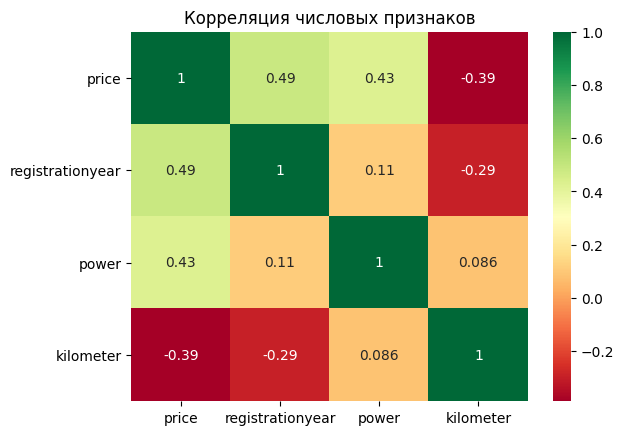

In [883]:
#Корреляция числовых признаков
sns.heatmap(df.corr(), cmap='RdYlGn', annot=True)
plt.title('Корреляция числовых признаков')
plt.show()

Мультиколлинеарности не наблюдается.  Больше всего на цену автомобиля влияет год регистрации и мощность.

### Выводы:
При анализе данных обнаружены и исправлены ряд недочетов в отчете (для устранения шума и более корректного дальнейшего построения моделей)
 - Удалены данные с ценой ниже 10 евро (целевой признак)
 - удалены данные с регистрацией авто до 1930(выбросы) и после 2017 года(т.к. последнее обьявление датируется 2016 годом)
 - удалены машины с мощность менее 20 л.с (выбросы) и более 2000(на сегодняшний день это максимум в автопроме)
 - заменены пустые значения в столбце fueltype(тип топлива) на petrol(наиболее популярное топливо для авто)
 - заменены пропуски в данных: тип кузова(vehicletype) - 4% пропусков,коробка передач(gearbox)- 2%, модель авто(model)- 4%,наличие ремонта(repaired)- 14% на `unknown`
 - удалены столбцы дата скачивания анкеты из базы(datecrawled), месяц регистрации автомобиля(registrationmonth), дата создания анкеты(datecreated),количество фотографий автомобиля(numberofpictures), почтовый код владельца анкеты(postalcode), дата последней активности пользователя(lastseen), так как эти данне для построения модели неважны
 - Мультиколлинеарности не наблюдается.  Больше всего на цену автомобиля влияет год регистрации и мощность.
 
 

<div class='alert alert-warning'>⚠️Хорошо, еще можно отфильтровать дубли 
</div>

## Обучение моделей

### План действий

Для прогнозирования цены автомобиля будем использовать следующие модели:

 - LinearRegression,
 - Ridge,
 - LightGBM,
 - CatBoost

План действий для моделей LinearRegression, Ridge:

1. Разделить данные на признаки и целевой признак(features, target)
2. Разделить на выборки: обучающую (20%) ,тестовую(20%)
3. Провести прямое кодирование( изменение категориальных признаков в числовые)
4. Масштабировать признаки
5. Исследование моделей:
    - LinearRegression
    - Ridge
6. Рассчитать время обучения и время предсказания, а также RMSE моделей
    

Модели градиентного бустинга не нуждаются в кодировании категориальных признаков

План действий для моделей LightGBM, CatBoost:
1. Разделить данные на признаки и целевой признак(features, target)
2. Разделить на выборки: обучающую (20%) ,тестовую(20%)
3. Масштабировать признаки
4. Исследование моделей:
    - LightGBM
    - CatBoost
5. Рассчитать время обучения и время предсказания, а также RMSE моделей

### Подготовка данных для моделей LinearRegression, Ridge

In [884]:
# деление на признаки и целевой признак(features, target)
features = df.drop(['price'], axis=1)
target = df['price']

# деление на выборки: train(80%) и test(20%)
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                              test_size=0.2, 
                                                                              random_state=12345)

#проверка
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(236562, 9)
(236562,)
(59141, 9)
(59141,)


In [885]:
#категориальные признаки для OHE 
ohe_features = ['vehicletype', 'gearbox','model', 'fueltype', 'brand', 'repaired']

In [886]:
# изменение категориальных признаков в числовые, с использованием техники OHE
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore',sparse=False)
#обучение на тестовой выборке на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features]) 

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [887]:
# добавляем закодированные признаки в features_train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_linear = features_train.drop(ohe_features, axis=1)
#проверка результата
features_train_linear.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
212727,2002,125,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29172,2011,120,90000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171812,2013,200,50000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
281296,2005,163,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
298552,2001,131,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [888]:
#применение на тестовой выборке
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])
features_test_linear = features_test.drop(ohe_features, axis=1)
#проверка результата
features_test_linear.head()

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
141784,2004,80,90000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70255,2002,101,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43951,2011,170,150000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
313495,2006,224,150000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149203,2000,61,100000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [889]:
#масштабирование данных
#числовые признаки numeric
numeric = ['registrationyear', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train_linear[numeric])
features_train_linear[numeric] = scaler.transform(features_train_linear[numeric])
features_test_linear[numeric] = scaler.transform(features_test_linear[numeric])
pd.options.mode.chained_assignment=None
#проверка
display(features_train_linear.head(3))
print(features_train_linear.shape)
print(features_test_linear.shape)

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
212727,-0.126931,0.055199,0.590755,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29172,1.257070,-0.024628,-1.045149,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171812,1.564626,1.252610,-2.135752,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


(236562, 309)
(59141, 309)


### Подготовка данных для  моделей LightGBM, CatBoost:

Модели градиентного бустинга не нуждаются в кодировании категориальных признаков,т.е. проделываем все те же действия, только минуя шаг с OHE 

Для начала изменим тип данных object на  category(модели не работают с типом данных object, таксже стоит отметить одно из основных преимуществ категориальных типов данных - более эффективное использование памяти)

In [890]:
categorical = ['vehicletype', 'gearbox','model', 'fueltype', 'brand', 'repaired']

for col in categorical:
    df[col] = df[col].astype('category')
#проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295703 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   price             295703 non-null  int64   
 1   vehicletype       295703 non-null  category
 2   registrationyear  295703 non-null  int64   
 3   gearbox           295703 non-null  category
 4   power             295703 non-null  int64   
 5   model             295703 non-null  category
 6   kilometer         295703 non-null  int64   
 7   fueltype          295703 non-null  category
 8   brand             295703 non-null  category
 9   repaired          295703 non-null  category
dtypes: category(6), int64(4)
memory usage: 13.3 MB


Далее снова разделим датасет на обучающую и тестовую выборки 

In [891]:
target_boost = df['price']
features_boost = df.drop('price', axis=1)
#деление на выборки: train_boost(80%) и test_boost(20%)
features_train_boost, features_test_boost, target_train_boost, target_test_boost = train_test_split(features_boost,
                                                                                                    target_boost,
                                                                              test_size=0.2, 
                                                                              random_state=12345)

#проверка
print(features_train_boost.shape)
print(target_train_boost.shape)
print(features_test_boost.shape)
print(target_test_boost.shape)

(236562, 9)
(236562,)
(59141, 9)
(59141,)


In [892]:
#масштабирование данных 
#числовые признаки numeric
numeric = ['registrationyear', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train_boost[numeric])
features_train_boost[numeric] = scaler.transform(features_train_boost[numeric])
features_test_boost[numeric] = scaler.transform(features_test_boost[numeric])
pd.options.mode.chained_assignment=None
#проверка
display(features_train_boost.head(3))
print(features_train_boost.shape)
print(features_test_boost.shape)

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
212727,sedan,-0.126931,manual,0.055199,vectra,0.590755,petrol,opel,no
29172,sedan,1.257070,manual,-0.024628,other,-1.045149,petrol,alfa_romeo,no
171812,coupe,1.564626,manual,1.252610,other,-2.135752,petrol,toyota,no


(236562, 9)
(59141, 9)


### Функция для запуска моделей

In [836]:
#проверка кода, для определения времени
print(time.time())
print (time.localtime(time.time()))
print (time.asctime( time.localtime(time.time()) ))


1684776624.1389282
time.struct_time(tm_year=2023, tm_mon=5, tm_mday=22, tm_hour=20, tm_min=30, tm_sec=24, tm_wday=0, tm_yday=142, tm_isdst=0)
Mon May 22 20:30:24 2023


In [893]:
#функция обучения
# на вход: модель, обучающие  выборки, на выход: время обучения, скорость предсказания
def model_final(model, X_train, y_train):
    
    start_train = time.time() 
    model.fit(X_train, y_train) 
    train_time = time.time() - start_train  #продолжительность/время обучения
    
    start_pred = time.time()
    y_pred = model.predict(X_train)
    pred_time = time.time() - start_pred #время предсказания
    
    #rmse = mean_squared_error(y_train,y_pred) ** 0.5
    
    return train_time, pred_time

### Обучение модели

**Обучение модели LinearRegression**, с предварительным подбором гиперпараметров с помощью GridSearchCV

In [894]:
#параметры для проведения GridSearchCV (подбор лучших параметров)
model = LinearRegression()
parameters_LR = {}
scorer = make_scorer(mean_squared_error, greater_is_better=False)

#подбор параметров модели 
grid_LR = GridSearchCV(estimator= model, param_grid=parameters_LR, cv=5, scoring = scorer)
grid_LR.fit(features_train_linear, target_train)
#запуск обучения(с использованием функции)
train_time_LR, pred_time_LR = model_final(grid_LR.best_estimator_, features_train_linear,target_train)

best_score_LR = grid_LR.best_score_
best_model_LR = grid_LR.best_estimator_
print('Время обучения при использовании модели LinearRegression:',round(train_time_LR, 2),'sec')
print('Скорость предсказаний модели LinearRegression:', round(pred_time_LR,2), 'sec')
print(f'Лучший результат RMSE: {round((best_score_LR*(-1))**0.5,2)} euro')
print(f'Лучшая модель: {best_model_LR}')


Время обучения при использовании модели LinearRegression: 6.96 sec
Скорость предсказаний модели LinearRegression: 0.06 sec
Лучший результат RMSE: 2666.1 euro
Лучшая модель: LinearRegression()


**Обучение модели Ridge**

In [895]:
model = Ridge()
parameters_Rid = {'max_iter': range(1,6),
                 'alpha': range(1,3),
                 'fit_intercept': [True, False]}

scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_Rid = GridSearchCV(estimator= model, param_grid=parameters_Rid, cv=5, scoring = scorer)
grid_Rid.fit(features_train_linear, target_train)
#запуск обучения(с использованием функции)
train_time_Rid, pred_time_Rid = model_final(grid_Rid.best_estimator_, features_train_linear,
                                                   target_train)
best_model_Rid = grid_Rid.best_estimator_
best_score_Rid = grid_Rid.best_score_

print('Ridge()')
print('Время обучения при использовании модели Ridge:',round(train_time_Rid, 2),'sec')
print('Скорость предсказаний модели Ridge:', round(pred_time_Rid,2), 'sec')
print(f'Лучший результат RMSE: {round((best_score_Rid*(-1))**0.5,2)} euro')
print(f'Лучшая модель: {best_model_Rid}') 


Ridge()
Время обучения при использовании модели Ridge: 0.74 sec
Скорость предсказаний модели Ridge: 0.07 sec
Лучший результат RMSE: 2665.98 euro
Лучшая модель: Ridge(alpha=1, max_iter=1)


**Обучение модели LightGBM**

In [896]:
categorical = ['vehicletype', 'gearbox','model', 'fueltype', 'brand', 'repaired']
model  = LGBMRegressor(categorical_feature=categorical)

parameters_lgbm = {'num_leaves': [30,40,50,60],
                 'n_estimators': [100, 200],
                  'learning_rate': [0.05, 0.1]}

scorer = make_scorer(mean_squared_error, greater_is_better=False)

grid_lgbm = GridSearchCV(estimator= model, param_grid=parameters_lgbm, cv=5, scoring = scorer)
grid_lgbm.fit(features_train_boost, target_train_boost)

#запуск обучения(с использованием функции)
train_time_lgbm, pred_time_lgbm = model_final(grid_lgbm.best_estimator_, features_train_boost, target_train_boost)

best_score_lgbm = grid_lgbm.best_score_
best_model_lgbm = grid_lgbm.best_estimator_

print('LightGBM()')
print('Время обучения при использовании модели LightGBM:',round(train_time_lgbm, 2),'sec')
print('Скорость предсказаний модели LightGBM:', round(pred_time_lgbm,2), 'sec')
print(f'Лучший результат RMSE: {round((best_score_lgbm*(-1))**0.5,2)} euro')
print(f'Лучшая модель: {best_model_lgbm}') 

LightGBM()
Время обучения при использовании модели LightGBM: 4.36 sec
Скорость предсказаний модели LightGBM: 0.81 sec
Лучший результат RMSE: 1535.24 euro
Лучшая модель: LGBMRegressor(categorical_feature=['vehicletype', 'gearbox', 'model',
                                   'fueltype', 'brand', 'repaired'],
              n_estimators=200, num_leaves=60)


**Обучение модели CatBoost**

In [897]:
model = CatBoostRegressor(loss_function='RMSE', cat_features=categorical, silent=True)

parameters_catboost = {'iterations': [40,50,60,70],
                'depth':[2,4,6],
                  'learning_rate': [0.05, 0.1]}

scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid_catboost = GridSearchCV(estimator= model, param_grid=parameters_catboost, cv=5, scoring = scorer )
grid_catboost.fit(features_train_boost, target_train_boost)

#запуск обучения(с использованием функции)
train_time_catboost, pred_time_catboost = model_final(grid_catboost.best_estimator_, features_train_boost,
                                                                     target_train_boost)


best_score_catboost = grid_catboost.best_score_
best_model_catboost = grid_catboost.best_estimator_

print('CatBoost')
print('Время обучения при использовании модели CatBoost:',round(train_time_catboost, 2),'sec')
print('Скорость предсказаний модели CatBoost:', round(pred_time_catboost,2), 'sec')
print(f'Лучший результат RMSE: {round((best_score_catboost*(-1))**0.5,2)} euro')
print(f'Лучшая модель: {best_model_catboost}')

CatBoost
Время обучения при использовании модели CatBoost: 1.83 sec
Скорость предсказаний модели CatBoost: 0.12 sec
Лучший результат RMSE: 1805.04 euro
Лучшая модель: <catboost.core.CatBoostRegressor object at 0x11a5d9e20>


**Обучение модели DummyRegressor**

In [ ]:
Обучим также констатную модель для сравнения результатов 

In [898]:
#построение констaнтной модели 


dummy = DummyRegressor(strategy="mean")
train_time_dummy, pred_time_dummy = model_final(dummy, features_train_linear,target_train)
rmse_dummy = mean_squared_error(target_train,dummy_predict)**0.5

print('Dummy')
print(f'Время обучения: {round(train_time_dummy,2)} sec')
print('Скорость предсказаний модели Dummy:', round(pred_time_dummy,2), 'sec')
print(f'Результат RMSE: {round(rmse_dummy,2)} euro')


Dummy
Время обучения: 0.0 sec
Скорость предсказаний модели Dummy: 0.0 sec
Результат RMSE: 4607.88 euro


## Анализ моделей

Для удобства сравнения внесем все данные в таблицу

In [899]:
#оформление итогов в виде таблицы

print('\033[1m' + '\nСравнение результатов моделей ' + '\033[0m')

df_total = {'Время обучения,сек ':[round(train_time_LR, 2), 
                                   round(train_time_Rid, 2) ,
                                   round(train_time_lgbm, 2), 
                                   round(train_time_catboost, 2), 
                                   round(train_time_dummy, 2)],
            'Скорость предсказания,сек ':[round(pred_time_LR,2), 
                                   round(pred_time_Rid,2) ,
                                   round(pred_time_lgbm,2), 
                                   round(pred_time_catboost,2), 
                                   round(train_time_dummy, 2)],
        
           'RMSE на train, евро': [round((best_score_LR*(-1))**0.5,2),
                          round((best_score_Rid*(-1))**0.5,2), 
                          round((best_score_lgbm*(-1))**0.5,2), 
                          round((best_score_catboost*(-1))**0.5,2),
                          round(rmse_dummy,2)]
           }


#pd.set_option('display.float_format', '{:.2f}'.format)
table__total = pd.DataFrame(df_total)

table__total.index = ['LinearRegression', 'Ridge','LightGBM','CatBoost', 'DummyRegressor']

display(table__total)


Сравнение результатов моделей 


,"Время обучения,сек","Скорость предсказания,сек","RMSE на train, евро"
LinearRegression,6.96,0.06,2666.10
Ridge,0.74,0.07,2665.98
LightGBM,4.36,0.81,1535.24
CatBoost,1.83,0.12,1805.04
DummyRegressor,0.00,0.00,4607.88


Использовали 4 модели для предсказания значения RMSE ( две линейные и две градиентного спуска) 
В данном случае наглядно видно, что в сравнении с DummyRegressor все модели сработали хорошо, и любая из наших моделей более предсказуема.
Лучшие результаты показала модель LightGBM.
Проведем финальное тестирование на тестовой выборке


### Проверка модели на тестовой выборке

In [901]:
# финальное тестирование на лучшей модели LightGBM
predict_test = best_model_lgbm.predict(features_test_boost)
rmse_test = mean_squared_error(target_test_boost,predict_test)**0.5
print(f'RMSE на тестовой выборке: {round(rmse_test,2)} евро')

RMSE на тестовой выборке: 1531.79 евро


## Общий вывод

 - В работе были рассмотрены  данных от сервиса по продаже автомобилей(данные о технических характеристиках, комплектации и ценах других автомобилей), необходимо было создать модель для расчета рыночной стоимости автомобиля.

 - В ходе исследования были подготовлены данные(заполнены пустые значения в столбцах, удалены аномалии и выбросы). Мультиколлинеарности не обнаружено. Наибольшее влияние на цену оказывает мощность и год регистрации.
 
 - На скорректированных данных обучили 4 модели (две линейные и две градиентного спуска).Критерии важные для заказчика:  качество предсказания, время обучения и время предсказания модели.  Но невозможно достичь минимума сразу по всем параметрам, поэтому нужно выбрать, что важнее.
 - Наиболее интересные  результаты показала модель LightGBM, на обучающей выборке  значение RMSE составляет 1535 евро, но по продолжительности обучения (3.43 сек) модель уступает линейным моделям. 
 - При проверке на тестовой выборке модель LightGBM показала значение RMSE 1531 евро .
 